In [56]:
# Initialize OK
from client.api.notebook import Notebook
ok = Notebook('hw7.ok')

Assignment: hw7
OK, version v1.13.11



# Homework 7: Gradient Descent, Logistic Regression
## Due Date:  Saturday 11/9, 11:59 PM

## This Assignment

This assignments consists of 3 parts. In these parts, we will:

1. Implement gradient descent, and show how it can be used to minimize arbitrary functions, even including loss functions for non-linear models.
2. Use numerical optimization to fit a multiple linear regression model. In this part we will also get practice with one-hot encoding and explore how redundant features in a model can cause problems for our closed form solution.
3. Explore concepts from classification including precision, recall, and cross-entropy loss.


Note that this homework will use bold notation rather than arrow notation to represent vectors, i.e. $\mathbf{x}$ instead of $\vec{x}$. There is no conceptual difference, only a cosmetic difference.

## Collaboration Policy

Data science is a collaborative activity. While you may talk with others about the homework, we ask that you **write your solutions individually**. If you do discuss the assignments with others please **include their names** in the cell below.

**Collaborators:** ...

## Point Distribution
| Question | Points | 
|----------|--------|
| 1 | 1 |
| 2a | 2 |
| 2b | 2 |
| 3a | 2 |
| 3b | 2 |
| 3c | 1 |
| 4a | 1 |
| 4b | 1 |
| 5 | 1 |
| 6a | 2 |
| 6b | 1 |
| 6c | 1 |
| 7 | 1 |
| 8a | 1 |
| 8b | 1 |
| 9 | 2 |

# Part 0: Preliminaries

In [57]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import re
import seaborn as sns
import sklearn
import sklearn.datasets
import sklearn.linear_model

np.random.seed(42)
plt.style.use('fivethirtyeight')
sns.set()
sns.set_context("talk")

# Set some parameters
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 16
np.set_printoptions(4)

# We will use plot_3d helper function to help us visualize gradient
from hw7_utils import plot_3d

%matplotlib inline

## Load Data
Load the data.csv file into a pandas dataframe.  
Note that we are reading the data directly from the URL address.

In [58]:
# Run this cell to load our sample data
part_1_data = pd.read_csv("https://github.com/DS-100/fa19/raw/gh-pages/assets/datasets/hw7_data.csv", index_col=0)
part_1_data.head()

,x,y
0,-5.000000,-7.672309
1,-4.966555,-7.779735
2,-4.933110,-7.995938
3,-4.899666,-8.197059
4,-4.866221,-8.183883


---
## A Simple Model
Let's start by examining our data and creating a simple model that can represent this data.

First, run the cell below to visualize our data.

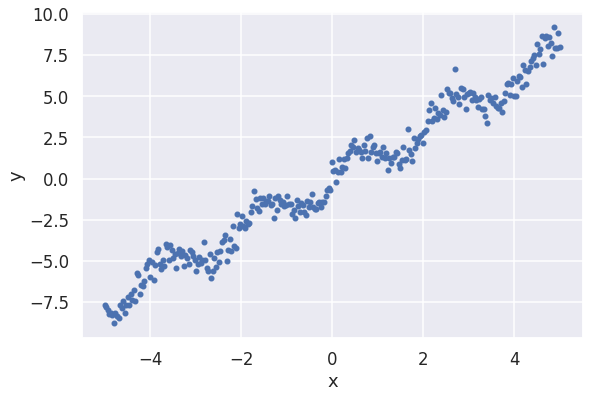

In [59]:
def scatter(x, y):
    """
    Generate a scatter plot using x and y

    Keyword arguments:
    x -- the vector of values x
    y -- the vector of values y
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, marker='.')
    plt.xlabel('x')
    plt.ylabel('y')
    
x = part_1_data['x']
y = part_1_data['y']
scatter(x,y)

The data looks roughly linear, with some extra sinusoidal noise. For now, let's assume that the data follows some underlying linear model. We define the underlying linear model that predicts the value $y$ using the value $x$ as: $f_{\beta^*}(x) = \beta^* \cdot x$

Since we cannot find the value of the population parameter $\beta^*$ exactly, we will assume that our dataset approximates our population and use our dataset to estimate $\beta^*$. We denote an estimate with $\beta$ and the fitted estimated chosen based on the data as $\hat{\beta}$. Our parameterized model is:

$$\Large
f_{\beta}(x) = \beta \cdot x
$$

Based on this equation, we will define the linear model function `linear_model` below to estimate $\textbf{y}$ (the $y$-values) given $\textbf{x}$ (the $x$-values) and $\beta$. This model is similar to the model you defined in the Modeling and Estimation lab.

In [60]:
def linear_model(x, beta):
    """
    Returns the estimate of y given x and beta

    Keyword arguments:
    x -- the vector of values x
    beta -- the scalar beta
    """
    return beta * x

In class, we learned that the squared loss function is smooth and continuous. Let's use squared loss to evaluate our estimate $\beta$, which we will use later to identify an optimal $\beta$, denoted $\hat{\beta}$. For several points, we compute the average loss or *empirical risk*.

In [61]:
def average_squared_loss(y, y_hat):
    """
    Returns the averge squared loss for observations y and predictions y_hat.

    Keyword arguments:
    y -- the vector of true values y
    y_hat -- the vector of predicted values y_hat
    """
    return np.mean((y - y_hat) ** 2)

Finally, we will visualize the average squared loss as a function of $\beta$, where several different values of $\beta$ are given.

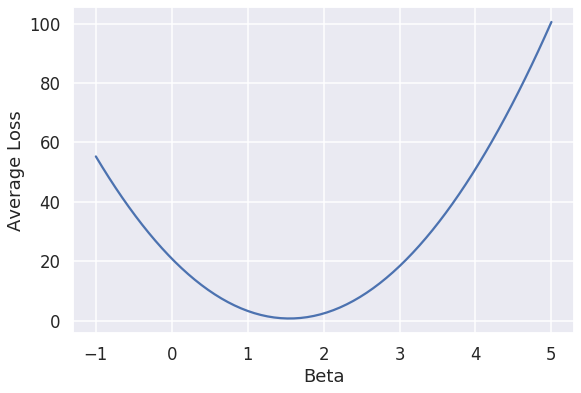

In [62]:
def visualize(x, y, betas):
    """
    Plots the average l2 loss for given x, y as a function of beta.
    Use the functions you wrote for linear_model and l2_loss.

    Keyword arguments:
    x -- the vector of values x
    y -- the vector of values y
    betas -- an array containing different estimates of the scalar beta
    """ 
    avg_loss = np.array([average_squared_loss(linear_model(x, beta), y) for beta in betas])
    plt.figure(figsize=(8,6))
    plt.plot(betas, avg_loss)
    plt.xlabel("Beta")
    plt.ylabel("Average Loss")
    
betas = np.linspace(-1, 5, 70)
visualize(x, y, betas)

You should notice that $\hat{\beta}$ is approximately 1.5. 

---
## 1: Fitting our Simple Model
Now that we have defined a simple linear model and loss function, let's begin working on fitting our model to the data.

### Question 1
Let's confirm our visual findings for optimal $\hat{\beta}$.

Recall from homework 6 that the analytical solution for the optimal $\hat{\beta}$ for the average squared loss is: 

$$\hat{\beta} = \frac{\sum_{i=1}^n x_i y_i}{\sum_{i=1}^n x_i^2}$$

Now that we have the analytic solution for $\hat{\beta}$, implement the function `find_beta` that calculates the numerical value of $\hat{\beta}$ based on our data $\textbf{x}$, $\textbf{y}$.

<!--
BEGIN QUESTION
name: q1
points: 1
-->

In [63]:
def find_beta(x, y):
    """
    Find optimal beta given x and y

    Keyword arguments:
    x -- the vector of values x
    y -- the vector of values y
    """
    return sum((x-np.mean(x)) * (y - np.mean(y)))/sum((x-np.mean(x))**2)

beta_hat = find_beta(x,y)
print(f'beta_hat = {beta_hat}')

beta_hat = 1.550264808596221


In [64]:
ok.grade("q1");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



Now, let's plot our risk function again using the `visualize` function. But this time, we will add a vertical line at the optimal value of beta (plot the line $x = \hat{\beta}$).

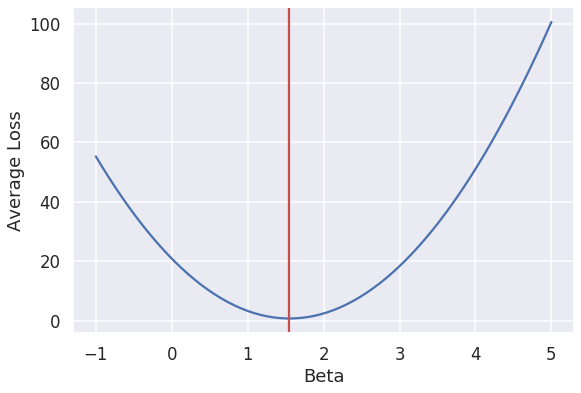

In [65]:
beta_opt = find_beta(x, y)
visualize(x, y, betas)
plt.axvline(x=beta_opt, color='r');

We now have an optimal value for $\beta$ that minimizes the empirical risk. We can use the scatter plot of the data and add the line $f_{\hat{\beta}}(x) = \hat{\beta} \cdot \textbf{x}$ using the $\hat{\beta}$ computed above.

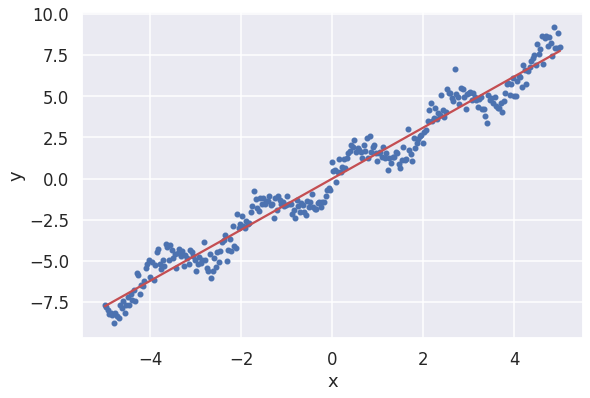

In [66]:
beta_opt = find_beta(x, y)
scatter(x, y)
line_values = linear_model(x, beta_opt)
plt.plot(x, line_values, color='r');

Great! It looks like our estimator $f_{\hat{\beta}}(x)$ is able to estimate the average y for each x quite well using a single parameter $\beta$. 

The remaining data is known as the residual, $\textbf{r}=\textbf{y}-\hat{\theta} \cdot \textbf{x}$. Below, we find the residual and plot the residuals corresponding to $x$ in a scatter plot. We also plot a horizontal line at $y=0$ to assist visualization.

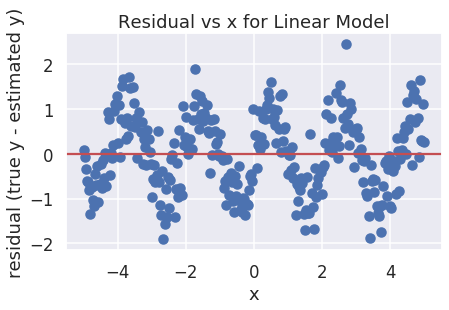

In [67]:
def visualize_residual(x, y):
    """
    Plot a scatter plot of the residuals, the remaining 
    values after removing the linear model from our data.

    Keyword arguments:
    x -- the vector of values x
    y -- the vector of values y
    """
    ...
    beta_hat = find_beta(x, y)
    y_sin = y - linear_model(x, beta_hat)
    plt.scatter(x, y_sin)
    plt.xlabel('x')
    plt.ylabel('residual (true y - estimated y)')
    plt.title('Residual vs x for Linear Model')
    plt.axhline(y=0, color='r')

visualize_residual(x, y)

## 2: Increasing Model Complexity

It looks like the remaining data is sinusoidal, meaning our original data follows a linear function and a sinusoidal function. Let's define a new model to address this discovery and find optimal parameters to best fit the data:

$$\Large
f_\boldsymbol\beta(x) = \beta_1x + sin(\beta_2x)
$$

Now, our model is parameterized by both $\beta_1$ and $\beta_2$, which we can combine in the vector, $\boldsymbol{\beta}$.

Note that a generalized sine function $a\sin(bx+c)$ has three parameters: amplitude scaling parameter $a$, frequency parameter $b$ and phase shifting parameter $c$. Looking at the residual plot above, it looks like the residual is zero at x = 0, and the residual swings between -1 and 1. Thus, it seems reasonable to effectively set the scaling and phase shifting parameter ($a$ and $c$ in this case) to 1 and 0 respectively. While we could try to fit $a$ and $c$, we're unlikely to get much benefit. When you're done with this homework, you can try adding $a$ and $c$ to our model and fitting these values to see if you can get a better loss.

We define the `sin_model` function below that predicts $\textbf{y}$ (the $y$-values) using $\textbf{x}$ (the $x$-values) based on our new equation.

In [68]:
def sin_model(x, beta):
    """
    Predict the estimate of y given x, beta_1, beta_2

    Keyword arguments:
    x -- the vector of values x
    beta -- a vector of length 2, where beta[0] = beta_1 and beta[1] = beta_2
    """
    beta_1 = beta[0]
    beta_2 = beta[1]
    return beta_1 * x + np.sin(beta_2 * x)

#### Question 2a

Recall the optimal value of $\beta$ should minimize our loss function. One way we've approached solving for $\beta$ is by taking the derivative of our loss function with respect to $\beta$, like we did in HW6.  

In the space below, use LaTeX to write/compute the following values:
* $R(\textbf{x}, \textbf{y}, \beta_1, \beta_2)$: our loss function, the empirical risk/mean squared error
* $\frac{\partial R }{\partial \beta_1}$: the partial derivative of $R$ with respect to $\theta_1$
* $\frac{\partial R }{\partial \beta_2}$: the partial derivative of $R$ with respect to $\theta_2$

<!--
BEGIN QUESTION
name: q2a
manual: True
points: 2
-->
<!-- EXPORT TO PDF -->


$R(\textbf{x}, \textbf{y}, \beta_1, \beta_2) = 1/n \sum{(y_i - \hat{y_i})^{2}} =1/n \sum{(y_i-(\beta_1x_i + sin(\beta_2x_i)))^{2}}$


$\frac{\partial R }{\partial \beta_1} = -2/n \sum{x_i((y_i-(\beta_1x_i + sin(\beta_2x_i)))}$


$\frac{\partial R }{\partial \beta_2} = -2/n \sum{cos(\beta_2x_i)((y_i-(\beta_1x_i + sin(\beta_2x_i)))}$

#### Question 2b
Now, implement the functions `sin_MSE`, `sin_MSE_dt1` and `sin_MSE_dt2`, which should compute $R$, $\frac{\partial R }{\partial \beta_1}$ and $\frac{\partial R }{\partial \beta_2}$ respectively. Use the formulas you wrote for $\frac{\partial R }{\partial \beta_1}$ and $\frac{\partial R }{\partial \beta_2}$ in the previous exercise. In the functions below, the parameter `beta` is a vector that looks like $( \beta_1, \beta_2 )$. We have completed `sin_MSE_gradient` for you.

Notes: 
* Keep in mind that we are still working with our original set of data, `part_1_data`
* To keep your code a bit more concise, be aware that `np.mean` does the same thing as `np.sum` divided by the length of the numpy array.

<!--
BEGIN QUESTION
name: q2b
points: 2
-->

In [69]:
def sin_MSE(beta):
    """
    Compute the numerical value of the l2 loss of our sinusoidal model given beta

    Keyword arguments:
    beta -- the vector of values beta
    """
    return np.mean((y-sin_model(x,beta))**2)

def sin_MSE_dt1(beta):
    """
    Compute the numerical value of the partial of l2 loss with respect to beta_1

    Keyword arguments:
    beta -- the vector of values beta
    """
    return -2*np.mean((x*(y-sin_model(x,beta))))
    
def sin_MSE_dt2(beta):
    """
    Compute the numerical value of the partial of l2 loss with respect to beta_2

    Keyword arguments:
    beta -- the vector of values beta
    """
    return -2*np.mean(x*(np.cos(beta[1]*x)*(y-sin_model(x,beta))))
    
# This function calls dt1 and dt2 and returns the gradient dt. It is already implemented for you.
def sin_MSE_gradient(beta):
    """
    Returns the gradient of l2 loss with respect to vector beta

    Keyword arguments:
    beta -- the vector of values beta
    """
    x = part_1_data['x']
    y = part_1_data['y']     
    return np.array([sin_MSE_dt1(beta), sin_MSE_dt2(beta)])

In [70]:
ok.grade("q2b");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 3
    Failed: 0
[ooooooooook] 100.0% passed



# Part 1: Gradient Descent
---
## 3: Gradient Descent

In lecture, we saw that there are a number of ways to optimize a linear model:

1. Brute force guess and check
2. Analytically derive a closed form solution
3. Use a numerical method like gradient descent

You can try to solve for the optimal $\hat{\mathbf{\beta}}$ analytically using your answers from 2a, but we don't recommend it. Notably, observe that the model is not even linear, e.g. it contains $\beta_2$ is inside a sine function.

To demonstrate how truly powerful techniques like gradient descent are, we'll use it in this homework to optimize our nonlinear model.

### Question 3

Let's now implement gradient descent. 

Note that the function you're implementing here is somewhat different than the gradient descent function we created in lecture. The version in lecture was `gradient_descent(df, initial_guess, alpha, n)`, where `df` was the gradient of the function we are minimizing, `initial_guess` are the starting parameters for that function. Here our signature is a bit different (described below).

#### Question 3a
Implement the `grad_desc` function that performs gradient descent for a finite number of iterations. This function takes in an array for $\textbf{x}$ (`x`), an array for $\textbf{y}$ (`y`), and an initial value for $\beta$ (`beta`). `alpha` will be the learning rate (or step size, whichever term you prefer). In this part, we'll use a static learning rate that is the same at every time step, just like in lecture.

At each time step, use the gradient and `alpha` to update your current `beta`. Also at each time step, be sure to save the current `beta` in `beta_history`, along with the average squared loss (computed with the current `beta`) in `loss_history`.

After completing the function, the cell will output the trajectory of your algorithm as it executed.

Hints:
- Write out the gradient update equation (1 step). What variables will you need for each gradient update? Of these variables, which ones do you already have, and which ones will you need to recompute at each time step?
- You may need a loop here to update `beta` several times
- Recall that the gradient descent update function follows the form:
$$\large
\boldsymbol\beta^{(t+1)} \leftarrow \boldsymbol\beta^{(t)} - \alpha \left(\nabla_\boldsymbol\beta \mathbf{R}(\textbf{x}, \textbf{y}, \boldsymbol\beta^{(t)}) \right)
$$

<!--
BEGIN QUESTION
name: q3a
points: 2
-->

In [71]:
def init_b():
    """Creates an initial beta [0, 0] of shape (2,) as a starting point for gradient descent"""
    return np.zeros((2,))

def grad_desc(loss_f, gradient_loss_f, beta, num_iter=20, alpha=0.1):
    """
    Run gradient descent update for a finite number of iterations and static learning rate

    Keyword arguments:
    loss_f -- the loss function to be minimized (used for computing loss_history)
    gradient_loss_f -- the gradient of the loss function to be minimized
    beta -- the vector of values beta to use at first iteration
    num_iter -- the max number of iterations
    alpha -- the learning rate (also called the step size)
    
    Return:
    beta -- the optimal value of beta after num_iter of gradient descent
    beta_history -- the series of beta values over each iteration of gradient descent
    loss_history -- the series of loss values over each iteration of gradient descent
    """
    beta_history = []
    loss_history = []
    i = 0
    while i <= num_iter:
        i+=1
        beta_history.append(beta)
        loss_history.append(loss_f(beta))
        beta = beta - alpha*gradient_loss_f(beta)
    return beta, beta_history, loss_history

beta_start = init_b()
beta_hat, betas_used, losses_calculated = grad_desc(sin_MSE, sin_MSE_gradient, beta_start, num_iter=20, alpha=0.1)
for b, l in zip(betas_used, losses_calculated):
    print(f"Beta: {b}, Loss: {l}")

Beta: [0. 0.], Loss: 20.859191416422235
Beta: [2.6011 2.6011], Loss: 9.285008173048674
Beta: [0.9034 2.591 ], Loss: 4.680169273815365
Beta: [2.0563 2.9631], Loss: 2.6242517936325824
Beta: [1.1589 2.8669], Loss: 1.4765157174727768
Beta: [1.7939 3.0728], Loss: 0.9073271435862446
Beta: [1.3216 3.0015], Loss: 0.5415316432911281
Beta: [1.6495 3.0291], Loss: 0.3775841142469479
Beta: [1.4233 2.9882], Loss: 0.2969750688130759
Beta: [1.583  3.0103], Loss: 0.2590425421375735
Beta: [1.471  2.9893], Loss: 0.23973439443291847
Beta: [1.5504 3.0017], Loss: 0.23034782416254634
Beta: [1.4944 2.9914], Loss: 0.2255775832667723
Beta: [1.5342 2.998 ], Loss: 0.22321772191904055
Beta: [1.506  2.9929], Loss: 0.2220236396720403
Beta: [1.526  2.9963], Loss: 0.2214281150026239
Beta: [1.5119 2.9938], Loss: 0.22112776381775162
Beta: [1.5219 2.9955], Loss: 0.22097741373654567
Beta: [1.5148 2.9942], Loss: 0.2209017318568303
Beta: [1.5198 2.9951], Loss: 0.2208637810584589
Beta: [1.5163 2.9945], Loss: 0.22084469777601

In [72]:
ok.grade("q3a");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 5
    Failed: 0
[ooooooooook] 100.0% passed



#### Question 3b
Now, let's try using a decaying learning rate. Implement `grad_desc_decay` below, which performs gradient descent with a learning rate that decreases slightly with each time step. You should be able to copy most of your work from the previous part, but you'll need to tweak how you update `beta` at each time step.

By decaying learning rate, we mean instead of just a number $\alpha$, the learning should be now $\frac{\alpha}{i+1}$ where $i$ is the current number of iteration. (Why do we need to add a '+ 1' in the denominator?)

<!--
BEGIN QUESTION
name: q3b
points: 2
-->

In [73]:
def init_b():
    """Creates an initial beta [0, 0] of shape (2,) as a starting point for gradient descent"""
    return np.zeros((2,))

def grad_desc_decay(loss_f, gradient_loss_f, beta, num_iter=20, alpha=0.1):
    """
    Run gradient descent update for a finite number of iterations and decaying learning rate

    Keyword arguments:
    loss_f -- the loss function to be minimized (used for computing loss_history)
    gradient_loss_f -- the gradient of the loss function to be minimized
    beta -- the vector of values beta to use at first iteration
    num_iter -- the max number of iterations
    alpha -- the learning rate (also called the step size)
    
    Return:
    beta -- the optimal value of beta after num_iter of gradient descent
    beta_history -- the series of beta values over each iteration of gradient descent,
                     should include the starting and ending beta (i.e. num_iter + 1 items)
    loss_history -- the series of loss values over each iteration of gradient descent, 
                     should include the starting and ending beta (i.e. num_iter + 1 items)
    """
    beta_history = []
    loss_history = []
    i = 0
    while i <= num_iter:
        i+=1
        beta_history.append(beta)    
        loss_history.append(loss_f(beta))
        beta = beta - alpha/(i)*gradient_loss_f(beta)
    return beta, beta_history, loss_history

beta_start = init_b()
beta_hat_decay, betas_used_decay, losses_calculated_decay =  grad_desc_decay(sin_MSE, sin_MSE_gradient, beta_start, num_iter=20, alpha=0.1)
for b, l in zip(betas_used_decay, losses_calculated_decay):
    print(f"Beta: {b}, Loss: {l}")

Beta: [0. 0.], Loss: 20.859191416422235
Beta: [2.6011 2.6011], Loss: 9.285008173048674
Beta: [1.7522 2.596 ], Loss: 0.9288337694245621
Beta: [1.6615 2.6585], Loss: 0.6305856872695186
Beta: [1.6273 2.7024], Loss: 0.5179242520135393
Beta: [1.6087 2.7343], Loss: 0.4536377194694131
Beta: [1.5965 2.7586], Loss: 0.4114290388213218
Beta: [1.5877 2.7778], Loss: 0.3815325686971529
Beta: [1.5811 2.7934], Loss: 0.3592636818660555
Beta: [1.5757 2.8064], Loss: 0.3420565889244843
Beta: [1.5714 2.8174], Loss: 0.3283808643419035
Beta: [1.5677 2.8269], Loss: 0.31726555449704147
Beta: [1.5646 2.8352], Loss: 0.30806465582511794
Beta: [1.5619 2.8425], Loss: 0.30033167881868716
Beta: [1.5595 2.849 ], Loss: 0.29374821207873686
Beta: [1.5575 2.8549], Loss: 0.28808113989505213
Beta: [1.5556 2.8602], Loss: 0.28315593305127174
Beta: [1.5539 2.865 ], Loss: 0.27883937959562793
Beta: [1.5524 2.8693], Loss: 0.2750280789874102
Beta: [1.551  2.8734], Loss: 0.27164057401067787
Beta: [1.5498 2.8771], Loss: 0.2686118461

In [74]:
ok.grade("q3b");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 4
    Failed: 0
[ooooooooook] 100.0% passed



Let's visually inspect our results of running gradient descent to optimize $\boldsymbol\beta$. The code below plots our $x$-values with our model's predicted $\hat{y}$-values over the original scatter plot. You should notice that gradient descent successfully optimized $\boldsymbol\beta$.

In [75]:
b = init_b()
b_est, bs, loss = grad_desc(sin_MSE, sin_MSE_gradient, b)

b = init_b()
b_est_decay, bs_decay, loss_decay = grad_desc_decay(sin_MSE, sin_MSE_gradient, b)

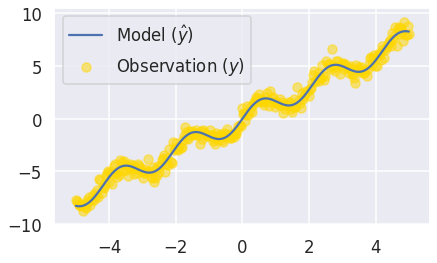

In [76]:
y_pred = sin_model(x, b_est)

plt.plot(x, y_pred, label='Model ($\hat{y}$)')
plt.scatter(x, y, alpha=0.5, label='Observation ($y$)', color='gold')
plt.legend();

Run the following cell to see a plot of the loss values over each iteration of gradient descent for both static learning rate and decaying learning rate. 

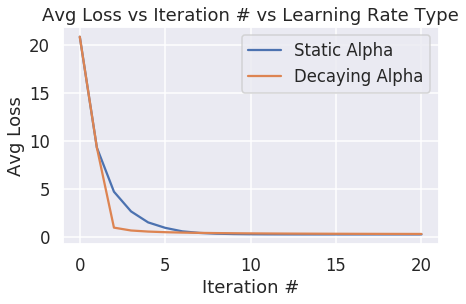

In [77]:
plt.plot(np.arange(len(loss)), loss, label='Static Alpha')
plt.plot(np.arange(len(loss)), loss_decay, label='Decaying Alpha')
plt.xlabel('Iteration #')
plt.ylabel('Avg Loss')
plt.title('Avg Loss vs Iteration # vs Learning Rate Type')
plt.legend();

---
## Visualizing Loss
Let's visualize our loss functions and gain some insight as to how gradient descent optimizes our model parameters.

In the previous plot we saw the loss decrease with each iteration. In this part, we'll see the trajectory of the algorithm as it travels the loss surface? Run the following cells to see visualization of this trajectory. 

In [78]:
bs = np.array(bs).squeeze()
bs_decay = np.array(bs_decay).squeeze()
loss = np.array(loss)
loss_decay = np.array(loss_decay)
bs

array([[0.    , 0.    ],
       [2.6011, 2.6011],
       [0.9034, 2.591 ],
       [2.0563, 2.9631],
       [1.1589, 2.8669],
       [1.7939, 3.0728],
       [1.3216, 3.0015],
       [1.6495, 3.0291],
       [1.4233, 2.9882],
       [1.583 , 3.0103],
       [1.471 , 2.9893],
       [1.5504, 3.0017],
       [1.4944, 2.9914],
       [1.5342, 2.998 ],
       [1.506 , 2.9929],
       [1.526 , 2.9963],
       [1.5119, 2.9938],
       [1.5219, 2.9955],
       [1.5148, 2.9942],
       [1.5198, 2.9951],
       [1.5163, 2.9945]])

In [79]:
# Run me to see a 3D plot (gradient descent with static alpha)
plot_3d(bs[:, 0], bs[:, 1], loss, average_squared_loss, sin_model, x, y)

In [80]:
# Run me to see another 3D plot (gradient descent with decaying alpha)
plot_3d(bs_decay[:, 0], bs_decay[:, 1], loss_decay, average_squared_loss, sin_model, x, y)

Another common way of visualizing 3D dynamics is with a _contour_ plot. Run the following cells.

In [81]:
import plotly
import plotly.graph_objs as go
plotly.offline.init_notebook_mode(connected=True)

In [82]:
def contour_plot(title, beta_history, loss_function, model, x, y):
    """
    The function takes the following as argument:
        beta_history: a (N, 2) array of beta history
        loss: a list or array of loss value
        loss_function: for example, l2_loss
        model: for example, sin_model
        x: the original x input
        y: the original y output
    """
    beta_1_series = beta_history[:,0] # a list or array of beta_1 value
    beta_2_series = beta_history[:,1] # a list or array of beta_2 value

    ## In the following block of code, we generate the z value
    ## across a 2D grid
    b1_s = np.linspace(np.min(beta_1_series) - 0.1, np.max(beta_1_series) + 0.1)
    b2_s = np.linspace(np.min(beta_2_series) - 0.1, np.max(beta_2_series) + 0.1)

    x_s, y_s = np.meshgrid(b1_s, b2_s)
    data = np.stack([x_s.flatten(), y_s.flatten()]).T
    ls = []
    for b1, b2 in data:
        l = loss_function(model(x, np.array([b1, b2])), y)
        ls.append(l)
    z = np.array(ls).reshape(50, 50)
    
    # Create trace of beta point
    # Create the contour 
    beta_points = go.Scatter(name="Beta Values", 
                              x=beta_1_series, 
                              y=beta_2_series,
                              mode="lines+markers")
    lr_loss_contours = go.Contour(x=b1_s, 
                                  y=b2_s, 
                                  z=z, 
                                  colorscale='Viridis', reversescale=True)

    plotly.offline.iplot(go.Figure(data=[lr_loss_contours, beta_points], layout={'title': title}))

In [83]:
contour_plot('Gradient Descent with Static Learning Rate', bs, average_squared_loss, sin_model, x, y)

In [84]:
contour_plot('Gradient Descent with Decay Learning Rate', bs_decay, average_squared_loss, sin_model, x, y)

### Question 3c: Analyzing Learning Rates

In 1-2 sentences, describe what you notice about the path that beta takes with a static learning rate vs. a decaying learning rate. In your answer, refer to either pair of plots above (the 3d plot or the contour plot).

<!--
BEGIN QUESTION
name: q3c
manual: true
points: 1
-->
<!-- EXPORT TO PDF -->

As we can see in both the 3d plot and the contour plot, the main difference between the static learning rate vs the decaying learning rate is that the static learning rate jumps back and forth from being below the optimal value to above it until it converges onto it. This is compared to the decaying learning rate which makes its first leap and then smoothens out as alpha decreases with each iteration, thus instead of jumping above and below, is more a smooth path towards the optimal value.

# Part 2: Multiple Regression

###  Question 4

Now, we will use gradient descent for linear regression. 

Along the way we'll also get some practice with one-hot encoding, and will see how linear dependence between features can cause us trouble with our analytic solutions.

To begin, let's load the tips dataset from the `seaborn` library.  This dataset contains records of tips, total bill, and information about the person who paid the bill. This is the same dataset used in Lab 9, so it should look familiar!

In [85]:
data = sns.load_dataset("tips")

print("Number of Records:", len(data))
data.head()

Number of Records: 244


,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


### Defining the Model and Feature Engineering

In the previous lab, we defined a simple linear model with only one parameter. Now let's make a more complicated model that utilizes other features in our dataset. Let our prediction for tip be a combination of the following features:

$$
\text{Tip} = \beta \cdot \text{total_bill} + \beta_2 \cdot \text{sex} + \beta_3 \cdot \text{smoker} + \beta_4 \cdot \text{day} + \beta_5 \cdot \text{time} + \beta_6 \cdot \text{size}
$$

Notice that some of these features are not numbers! But our linear model will need to predict a numerical value. Let's start by converting some of these non-numerical values into numerical values. Below we split the tips and the features.

In [86]:
tips = data['tip']
X = data.drop(columns='tip')

### Question 4a: Feature Engineering

First, let's convert our features to numerical values. A straightforward approach is to map some of these non-numerical features into numerical ones. 

For example, we can treat the day as a value from 1-7. However, one of the disadvantages in directly translating to a numeric value is that we unintentionally assign certain features disproportionate weight. Consider assigning Sunday to the numeric value of 7, and Monday to the numeric value of 1. In our linear model, Sunday will have 7 times the influence of Monday, which can lower the accuracy of our model.

Instead, let's use one-hot encoding to better represent these features! 

As discussed in lecture, one-hot encoding will produce a binary vector indicating the non-numeric feature. Sunday would be encoded as `[0 0 0 0 0 0 1]`. This assigns a more even weight across each category in non-numeric features. Complete the code below to one-hot encode our dataset, allowing us to see the transformed dataset named `one_hot_X`. This dataframe holds our "featurized" data, which is also often denoted by $\phi$ (see [lecture 17](http://www.ds100.org/fa19/resources/assets/lectures/lec17/17-FEandRegularization.pdf)). 

<!--
BEGIN QUESTION
name: q4a
points: 1
-->

In [87]:
def one_hot_encode(data):
    """
    Return the one-hot encoded dataframe of our input data.
    
    Parameters
    -----------
    data: a dataframe that may include non-numerical features
    
    Returns
    -----------
    A one-hot encoded dataframe that only contains numeric features
    
    Hint: Check out the pd.get_dummies function
    """
    return pd.get_dummies(data)
one_hot_X = one_hot_encode(X)
one_hot_X.head()

,total_bill,size,sex_Male,sex_Female,smoker_Yes,smoker_No,day_Thur,day_Fri,day_Sat,day_Sun,time_Lunch,time_Dinner
0,16.99,2,0,1,0,1,0,0,0,1,0,1
1,10.34,3,1,0,0,1,0,0,0,1,0,1
2,21.01,3,1,0,0,1,0,0,0,1,0,1
3,23.68,2,1,0,0,1,0,0,0,1,0,1
4,24.59,4,0,1,0,1,0,0,0,1,0,1


In [88]:
ok.grade("q4a");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



### Question 4b: Defining the Model

Now that all of our data is numeric, we can begin to define our model function. Notice that after one-hot encoding our data, we now have 12 features instead of 6. Therefore, our linear model now looks like:

$$
\text{Tip} = \beta_1 \cdot \text{size} + \beta_2 \cdot \text{total_bill} + \beta_3 \cdot \text{day_Thur} + \beta_4 \cdot \text{day_Fri} + ... + \beta_{11} \cdot \text{time_Lunch} + \beta_{12} \cdot \text{time_Dinner}
$$

We can represent the linear combination above as a matrix-vector product. Implement the `linear_model` function to evaluate this product.

**Hint**: You can use [`np.dot`](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.dot.html), [`pd.DataFrame.dot`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.dot.html), or the `@` operator to multiply matrices/vectors. However, while the `@` operator can be used to multiply `numpy` arrays, it generally will not work between two `pandas` objects, so keep that in mind when computing matrix-vector products!

<!--
BEGIN QUESTION
name: q4b
points: 1
-->

In [89]:
def linear_model(betas, X):
    """
    Return the linear combination of betas and features as defined above.
    
    Parameters
    -----------
    betas: a 1D vector representing the parameters of our model ([beta1, beta2, ...])
    X: a 2D dataframe of numeric features
    
    Returns
    -----------
    A 1D vector representing the linear combination of betas and features as defined above.
    """
    return np.dot(X, betas)

In [90]:
ok.grade("q4b");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 3
    Failed: 0
[ooooooooook] 100.0% passed



### Question 5: Fitting the Model using Numeric Methods

In principle, we could find the optimal beta by minimizing using your gradient descent function that you wrote in part 1 of this lab. This would require us to create a function that computes (or estimates) the derivative of the loss for tips model.

For this problem, to give you more practice with real world tools, you should instead use `scipy.optimize.minimize`, which is essentially the same thing as your gradient descent function, except that it requires only two arguments: The loss function to be minimized and your starting parameters for that function. That is, we don't need to explicit provide the gradient of our loss function as an argument. The loss function provided must take exactly one argument, just like with your gradient descent implementation.

While in lecture and earlier in this assignment, we often used `def` to create these one parameter loss functions (e.g. `sin_MSE`), in this problem you should use `lambda` instead. Many real world examples out there use `lambda` so it's good to get practice with this way of thinking.

<!--
BEGIN QUESTION
name: q5
points: 1
-->

In [91]:
from scipy.optimize import minimize

def l1(y, y_hat):
    return np.abs(y - y_hat)

def l2(y, y_hat):
    return (y - y_hat)**2

def minimize_average_loss(loss_function, model, X, y):
    """
    Minimize the average loss calculated from using different beta vectors, and 
    estimate the optimal beta for the model.
    
    Parameters
    -----------
    loss_function: either the squared or absolute loss functions defined above
    model: the model (as defined in Question 1b)
    X: a 2D dataframe of numeric features (one-hot encoded)
    y: a 1D vector of tip amounts
    
    Returns
    -----------
    The estimate for the optimal beta vector that minimizes our loss
    """
    
    ## Notes on the following function call which you need to finish:
    # 
    # 1. The first '...' should be replaced with the average loss evaluated on 
    #       the data X, y using the model and appropriate loss function.
    # 2. x0 are the initial values for BETA.  Yes, this is confusing
    #       but optimization people like x to be the thing they are 
    #       optimizing. Replace the second '...' with an initial value for beta,
    #       and remember that beta is now a vector. DO NOT hard-code the length of x0;
    #       it should depend on the number of features in X.

    return minimize(lambda beta: np.mean(loss_function(y, model(beta, X))), x0= np.ones(len(X.columns))*0)['x']
    # Notice above that we extract the 'x' entry in the dictionary returned by `minimize`. 
    # This entry corresponds to the optimal beta estimated by the function.

minimize_average_loss(l2, linear_model, one_hot_X, tips)

array([0.0945, 0.176 , 0.1841, 0.2166, 0.1571, 0.2435, 0.0152, 0.1775,
       0.056 , 0.152 , 0.2344, 0.1663])

In [92]:
ok.grade("q5");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



## Question 6: Fitting the Model using Analytic Methods

Let's also fit our model analytically for the l2 loss function. Recall from lecture that with a linear model, we are solving the following optimization problem for least squares:

$$\min_{\beta} ||X\beta - y||^2$$

We showed in lecture that the optimal $\hat{\beta}$ is:
$$\hat{\beta} = (X^T X)^{-1} X^T y$$

### Question 6a: Analytic Solution Using Explicit Inverses

You've done this before, but let's do it again. For this problem, implement the analytic solution above using `np.linalg.inv` to compute the inverse of X transpose times X.

Reminder: To compute the transpose of a matrix, you can use `X.T` or `X.transpose()`

In [93]:
def get_analytical_sol(X, y):
    """
    Computes the analytical solution to our least squares problem
    
    Parameters
    -----------
    X: a 2D dataframe of numeric features (one-hot encoded)
    y: a 1D vector of tip amounts
    
    Returns
    -----------
    The estimate for beta computed using the equation mentioned above
    """
    return np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)) ,X.T), y)

Now, run the cell below to find the analytical solution for the `tips` dataset. Depending on the machine that you run your code on, you should either see an error or end up with betas that are nonsensical (magnitudes greater than 10^15).

In [94]:
analytical_betas = get_analytical_sol(one_hot_X, tips)

LinAlgError: Singular matrix

In the cell below, explain why we got the error above when trying to calculate the analytical solution for our one-hot encoded `tips` dataset.

<!--
BEGIN QUESTION
name: q6a
manual: true
points: 2
-->
<!-- EXPORT TO PDF -->

We get this error because the product of X transpose and X is a singular matrix which means its determinant is zero and therefore this matrix does not have an inverse!

### Question 6b: Fixing our One-Hot Encoding

Now, let's fix our one-hot encoding approach so we don't get the error we did earlier. Complete the code below to one-hot-encode our dataset such that `one_hot_X_revised` has no redundant features.

**Hint:** Check out the `drop_first` parameter of `pd.get_dummies`.

<!--
BEGIN QUESTION
name: q6b
points: 1
-->

In [95]:
def one_hot_encode_revised(data):
    """
    Return the one-hot encoded dataframe of our input data, removing redundancies.
    
    Parameters
    -----------
    data: a dataframe that may include non-numerical features
    
    Returns
    -----------
    A one-hot encoded dataframe that only contains numeric features without any redundancies.
    
    Hint: Check out the drop_first parameter of the pd.get_dummies function.
    """
    return pd.get_dummies(data, drop_first = True)
    
one_hot_X_revised = one_hot_encode_revised(X)
revised_analytical_betas = get_analytical_sol(one_hot_X_revised, tips)
print("Our analytical loss is: ", l2(linear_model(revised_analytical_betas, one_hot_X_revised), tips).mean())
print("Our numerical loss is: ", l2(linear_model(minimize_average_loss(l2, linear_model, one_hot_X_revised, tips), one_hot_X_revised), tips).mean())

Our analytical loss is:  1.0332855708786617
Our numerical loss is:  1.0332855709135256


In [96]:
ok.grade("q6b");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



### Question 6c: Analyzing our new One-Hot Encoding

Why did removing redundancies in our one-hot encoding fix the problem we had in 6a?
<!--
BEGIN QUESTION
name: q6c
manual: true
points: 1
-->
<!-- EXPORT TO PDF -->

A singular matrix is a matrix which is linearly dependent meaning that there are nontrivial solutions and that the individual vectors are linearly related to each other. This is obvious of course if we look at the original one hot encoded matrix which split up, if we add each category that was split up then we can eventually get a column with 1's for every entry, and this would happen for all the columns which we split up in the one hot encoding. However, when we utilized the drop_first parameter, this drops the first column and hence alleviates this linear dependence since the columns will no longer add up to be the same things and the matrix will have full rank and hence is non-singular, linearly independent and invertible.

---

Note: An alternate approach is to use `np.linalg.solve` instead of `np.linalg.inv`. For the example above, even with the redundant features, `np.linalg.solve` will work well. Though in general, it's best to drop redundant features anyway.

In case you want to learn more, here is a relevant Stack Overflow post: https://stackoverflow.com/questions/31256252/why-does-numpy-linalg-solve-offer-more-precise-matrix-inversions-than-numpy-li

# Part III: Logistic Regression

In this final part of the HW, we will be working on the breast cancer dataset. This dataset can be easily loaded using the `sklearn.datasets.load_breast_cancer()` method. The data format is not a `pandas.DataFrame` so we will create a new DataFrame from it.

We will not cover the material needed for this homework until lecture on 11/5.

In [97]:
data = sklearn.datasets.load_breast_cancer()
# data is actually a dictionary
print(data.keys())
print(data.DESCR)

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names'])
Breast Cancer Wisconsin (Diagnostic) Database

Notes
-----
Data Set Characteristics:
    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Ra

In [98]:
df = pd.DataFrame(data.data, columns=data.feature_names)
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Let us try to fit a simple model with only one feature.

In [99]:
# Define our features/target
X = df[["mean radius"]]
# Target data['target'] = 0 is malignant 1 is benign
Y = (data.target == 0)

In [100]:
# Split between train and test
from sklearn.model_selection import train_test_split
x_train, x_test,y_train,y_test = train_test_split(X,Y, test_size=0.25, random_state=42)

print(f"Training Data Size: {len(x_train)}")
print(f"Test Data Size: {len(x_test)}")

Training Data Size: 426
Test Data Size: 143


### Question 7

Let's first fit a logistic regression model using the training set. 

For this problem, we will go one level of abstraction higher and simply use the existing LogisticRegression implementation in sklearn.

Fill in the code below so that you to compute the training and testing accuracy, defined as:

$$
\large
\text{Training Accuracy} = \frac{1}{n_{train\_set}} \sum_{i \in \text{train_set}} {\mathbb{1}_{y_i == \hat{y_i}}}
$$

$$
\large
\text{Testing Accuracy} = \frac{1}{n_{test\_set}} \sum_{i \in \text{test_set}} {\mathbb{1}_{y_i == \hat{y_i}}}
$$

where $\hat y_i $ is the prediction of our model, $ y_i $ the true value, and $\mathbb{1}_{y_i == \hat{y_i}}$ an indicator function ($ \mathbb{1}_{y_i == \hat{y_i}} = 1 $ if and only if  $ y_i = \hat{y_i}$).

<!--
BEGIN QUESTION
name: q7
points: 1
-->

In [101]:
lr = sklearn.linear_model.LogisticRegression(fit_intercept=True)

lr.fit(x_train,y_train) 
train_accuracy = np.mean(lr.predict(x_train)==y_train)
test_accuracy = np.mean(lr.predict(x_test)==y_test)

print(f"Train accuracy: {train_accuracy:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")

Train accuracy: 0.8732
Test accuracy: 0.9161


In [102]:
ok.grade("q7");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



## Question 8
### Question 8a: Confusion Matrices

It seems we can a get very high test accuracy. But how about precision and recall?  
- Precision is the fraction of instances you predicted as 1 that were actually 1.  
- Recall is the fraction of instances are actually 1 that you predicted as 1.

Precision measures the ability of the classifier not to label as positive a sample that is negative, while recall measures the ability of the classifier to find all the positive samples.

A **confusion matrix** helps us visualize/calculate the precision and recall of a classifier. Below, we compute the confusion matrix for our classifier.

We also compute the normalized confusion matrix, which is the same as the confusion matrix, but the numbers are converted to percents (sometimes it's easier to interpret percents as opposed to numbers, especially when the numbers are really big or small).

[[88  1]
 [11 43]]
[[0.9888 0.0112]
 [0.2037 0.7963]]


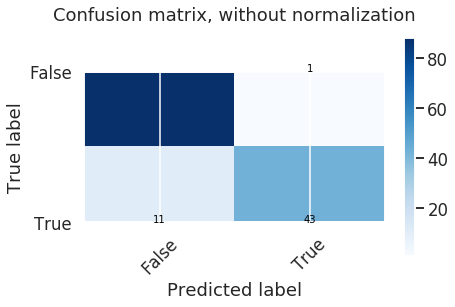

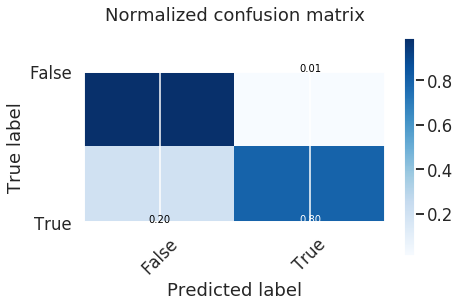

In [103]:
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(y_test, lr.predict(x_test))

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = "Normalized confusion matrix"
    else:
        title = 'Confusion matrix, without normalization'

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(title, y=1.3)
    
class_names = ['False', 'True']
# Plot non-normalized confusion matrix
plt.figure();
plot_confusion_matrix(cnf_matrix, classes=class_names);

# Plot normalized confusion matrix
plt.figure();
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True);

Mathematically:
$$
\text{Precision} = \frac{n_{true\_positives}}{n_{true\_positives} + n_{false\_positives}}
$$

$$
\text{Recall} = \frac{n_{true\_positives}}{n_{true\_positives} + n_{false\_negatives}}
$$

As illustrated in the figure below:
![precision_recall](precision_recall.png)

Now let's compute the precision and recall for the test set using the model we got from question 1.  
Please do not use the `sklearn.metrics` for this computation. Instead, use the formulas above.

**Hint:** You can do this without using any for loops, just using `y_pred` and `y_test`.

<!--
BEGIN QUESTION
name: q8a
points: 1
-->

In [104]:
y_pred = lr.predict(x_test) 

true_negative = sum((y_pred == y_test) & (y_test == 0))
true_positive = sum((y_pred == y_test) & (y_test == 1))
false_positive = sum((y_pred != y_test) & (y_test == 0))
false_negative = sum((y_pred != y_test) & (y_test == 1))

precision = true_positive/(true_positive+false_positive)#what percent of predicted trues were actually true
recall = true_positive/(true_positive+false_negative)#what percent of actual trues were predicted true

print(f'precision = {precision:.4f}')
print(f'recall = {recall:.4f}')

precision = 0.9773
recall = 0.7963


In [105]:
ok.grade("q8a");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



### Question 8b: Analyzing Precision and Recall

Our precision is fairly high, while our recall is a bit lower. Why may we observe these results?

**Hint:** Consider the distribution of true/false values in our data. 

<!--
BEGIN QUESTION
name: q8b
manual: true
points: 1
-->
<!-- EXPORT TO PDF -->

Our precision is high because we have a low amount of false positives. This is because we have a low amount of positives in general since the majority of our data (69%) are predicted as False. Thus, because of this majority, our recall is quite bad since a lot of values were predicted False that are actually true, hence the recall value is lower then our precision simply because the majority of our data was predicted as False making the values that were predicted as True to be more accurate, but at the same time missing some values that were actually True and were instead predicted as False.

In [106]:
sum(y_pred == False)/len(y_pred)

0.6923076923076923

##  Question 9
Now let's try to compute the cross entropy loss of our classifier. Recall that loss would be:
$$\Large L(\beta) = -\frac{1}{n} \sum_{i=1}^n \left( y_i \log(z_i) + (1 - y_i) \log(1 - z_i)  \right) $$

where $z_i = \sigma(\beta \cdot X_i)$.

In [107]:
beta = np.array([lr.coef_[0][0],
                  lr.intercept_[0]])
X_new = np.hstack([X,
                 np.ones([len(X), 1])]) # This is adding a coefficient of 1 for the intercept term
print(beta)
print()
print(X_new)

[ 0.4757 -7.2282]

[[17.99  1.  ]
 [20.57  1.  ]
 [19.69  1.  ]
 ...
 [16.6   1.  ]
 [20.6   1.  ]
 [ 7.76  1.  ]]


Implement the function `lr_loss` which computes the cross-entropy loss. Note that you have been given `sigmoid`, which implements the $\sigma$ function for you.
<!--
BEGIN QUESTION
name: q9
points: 2
-->

In [108]:
def sigmoid(t):
    return 1 / (1 + np.exp(-t))

def lr_loss(beta, X, Y):
    '''
    Compute the cross entropy loss using Phi, Y and beta. Hint: # The notation B @ v means: 
    compute the matrix multiplication Bv 

    Args:
        beta: The model parameters. 
        Phi: The transformed input data \phi(X)
        Y: The label 

    Return:
        The cross entropy loss.
    '''
    return -np.mean(Y*np.log(sigmoid(X@beta)) + (1-Y)*np.log(1-sigmoid(X@beta)))

In [109]:
ok.grade("q9");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



Before submitting, please make sure to restart your kernel and rerun your code to verify that tests are passing and images show up. You may submit as many times as you'd like; we will count your last submission.

# Submit
Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output.
**Please save before submitting!**

<!-- EXPECT 5 EXPORTED QUESTIONS -->

In [ ]:
# Save your notebook first, then run this cell to submit.
import jassign.to_pdf
jassign.to_pdf.generate_pdf('hw7.ipynb', 'hw7.pdf')
ok.submit()

Generating PDF...
Saved hw7.pdf
